<a href="https://colab.research.google.com/github/tztechno/cc_archive/blob/main/Multi_Size_Photos_Gaussian_Splat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.

In [ ]:

#サイズの異なる画像を扱う
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Fountain Photos: Gaussian Splat wo/Camera Info**



In [ ]:
import os
import sys
import subprocess
import shutil
from pathlib import Path
import cv2

# Configuration
# IMAGE_PATH: Path to the image folder
# WORK_DIR: Working directory for Gaussian Splatting repository
# OUTPUT_DIR: Directory for the final video output
# COLMAP_DIR: Directory for COLMAP data

IMAGE_PATH = "/content/drive/MyDrive/your_folder/british_data"
WORK_DIR = '/content/gaussian_splatting'
OUTPUT_DIR = '/content/output'
COLMAP_DIR = '/content/colmap_data'



In [ ]:
# CUDA環境変数
os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.0;7.5;8.0;8.6'
os.environ['FORCE_CUDA'] = '1'

In [ ]:
def setup_environment():
    """Install necessary packages and clone the repository"""
    print("Setting up environment...")

    # Virtual display setup
    print("Setting up virtual display...")
    subprocess.run(['apt-get', 'update', '-qq'], check=True)
    subprocess.run(['apt-get', 'install', '-y', '-qq', 'xvfb'], check=True)

    # Set DISPLAY environment variable
    os.environ['QT_QPA_PLATFORM'] = 'offscreen'
    os.environ['DISPLAY'] = ':99'

    # Start Xvfb
    subprocess.Popen(['Xvfb', ':99', '-screen', '0', '1024x768x24'])

    # Install COLMAP
    print("Installing COLMAP...")
    subprocess.run(['apt-get', 'install', '-y', '-qq', 'colmap'], check=True)

    # Install build dependencies for submodules
    print("Installing build dependencies...")
    subprocess.run([
        'apt-get', 'install', '-y', '-qq',
        'build-essential', 'cmake', 'git'
    ], check=True)

    # Clone Gaussian Splatting repository
    if not os.path.exists(WORK_DIR):
        print("Cloning Gaussian Splatting repository...")
        subprocess.run([
            'git', 'clone', '--recursive',
            'https://github.com/tztechno/gaussian-splatting.git',
            WORK_DIR
        ], check=True)

    os.chdir(WORK_DIR)

    # Install Python packages (including build tools)
    print("Installing Python packages...")
    subprocess.run([
        sys.executable, '-m', 'pip', 'install', '-q', '--upgrade',
        'pip', 'setuptools', 'wheel', 'ninja'
    ], check=True)

    subprocess.run([
        sys.executable, '-m', 'pip', 'install', '-q',
        'torch', 'torchvision', 'torchaudio',
        'plyfile', 'tqdm', 'opencv-python', 'pillow'
    ], check=True)

    submodules = ['diff-gaussian-rasterization', 'simple-knn']

    for submodule in submodules:
        print(f"Building {submodule}...")
        submodule_dir = f'{WORK_DIR}/submodules/{submodule}'
        os.chdir(submodule_dir)
        subprocess.run([sys.executable, 'setup.py', 'build_ext', '--inplace'], check=True)
        subprocess.run([sys.executable, 'setup.py', 'install'], check=True)
        os.chdir(WORK_DIR)

    print("Environment setup complete!")



In [ ]:
import os
import cv2
from PIL import Image
import glob
import numpy as np

def adjust_gamma(image, gamma=1.2):
    """gamma > 1.0 で明るく, gamma < 1.0 で暗くなる"""
    invGamma = 1.0 / gamma
    table = (np.array([((i / 255.0) ** invGamma) * 255
              for i in np.arange(0, 256)])).astype("uint8")
    return cv2.LUT(image, table)


def process_frames_from_folder(image_folder, output_dir, max_frames=300, supported_formats=['jpg', 'jpeg', 'png', 'bmp']):
    """Process frames from image folder instead of video"""
    print(f"Processing frames from folder: {image_folder}")

    os.makedirs(output_dir, exist_ok=True)

    # Search for supported image files
    image_files = []
    for fmt in supported_formats:
        pattern = os.path.join(image_folder, f"*.{fmt}")
        image_files.extend(glob.glob(pattern))
        pattern = os.path.join(image_folder, f"*.{fmt.upper()}")
        image_files.extend(glob.glob(pattern))

    # Sort by filename
    image_files.sort()

    if not image_files:
        raise ValueError(f"No image files found in: {image_folder}")

    print(f"Found {len(image_files)} image files")

    # Limit to maximum number of frames
    image_files = image_files[:max_frames]

    saved_count = 0

    for i, image_path in enumerate(image_files):
        try:
            # Read the image
            if image_path.lower().endswith(('.png','.jpeg','.bmp')):
                # Read with OpenCV (color space conversion may be needed)
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Warning: Could not read {image_path} with OpenCV, trying PIL")
                    pil_img = Image.open(image_path).convert('RGB') # Ensure RGB for conversion
                    img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            else:
                img = cv2.imread(image_path)

            if img is None:
                print(f"Warning: Could not read {image_path}, skipping")
                continue

            # brightness
            #img = adjust_gamma(img, gamma=1.1)
            print(img.shape)

            # Generate output path
            output_path = os.path.join(output_dir, f"frame_{saved_count:05d}.jpg")

            # Save the image
            cv2.imwrite(output_path, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
            saved_count += 1

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    print(f"Processed {saved_count} frames from folder")

    return saved_count



In [ ]:
def run_colmap_reconstruction(image_dir, colmap_dir):
    """Estimate camera poses and 3D point cloud with COLMAP"""
    print("Running SfM reconstruction with COLMAP...")

    database_path = os.path.join(colmap_dir, "database.db")
    sparse_dir = os.path.join(colmap_dir, "sparse")
    os.makedirs(sparse_dir, exist_ok=True)

    # Set environment variable
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'

    # Feature extraction
    print("1/4: Extracting features...")
    subprocess.run([
        'colmap', 'feature_extractor',
        '--database_path', database_path,
        '--image_path', image_dir,
        '--ImageReader.single_camera', '1',
        '--ImageReader.camera_model', 'OPENCV',
        '--SiftExtraction.use_gpu', '0'  # Use CPU
    ], check=True, env=env)


    # Feature matching #fixed fixed fixed
    # Feature matching
    print("2/4: Matching features...")
    subprocess.run([
        'colmap', 'exhaustive_matcher',#'sequential_matcher',  # Use sequential_matcher instead of exhaustive_matcher
        '--database_path', database_path,
        '--SiftMatching.use_gpu', '0',  # Use CPU

    #'--SiftMatching.max_error', '4.0',          # デフォルト4.0 → 5.0（寛容に）
    #'--SiftMatching.cross_ratio_test', '0.8',   # デフォルト0.8 → 0.7（厳密に）


    ], check=True, env=env)



    # Sparse reconstruction
    print("3/4: Sparse reconstruction...")
    subprocess.run([
        'colmap', 'mapper',
        '--database_path', database_path,
        '--image_path', image_dir,
        '--output_path', sparse_dir,
        '--Mapper.ba_global_max_num_iterations', '20',  # Speed up
        '--Mapper.ba_local_max_num_iterations', '10' #10
    ], check=True, env=env)

    # Export to text format
    print("4/4: Exporting to text format...")
    model_dir = os.path.join(sparse_dir, '0')
    if not os.path.exists(model_dir):
        # Use the first model found
        subdirs = [d for d in os.listdir(sparse_dir) if os.path.isdir(os.path.join(sparse_dir, d))]
        if subdirs:
            model_dir = os.path.join(sparse_dir, subdirs[0])
        else:
            raise FileNotFoundError("COLMAP reconstruction failed")

    subprocess.run([
        'colmap', 'model_converter',
        '--input_path', model_dir,
        '--output_path', model_dir,
        '--output_type', 'TXT'
    ], check=True, env=env)

    print(f"COLMAP reconstruction complete: {model_dir}")
    return model_dir

def convert_cameras_to_pinhole(input_file, output_file):
    """Convert camera model to PINHOLE format"""
    print(f"Reading camera file: {input_file}")

    with open(input_file, 'r') as f:
        lines = f.readlines()

    converted_count = 0
    with open(output_file, 'w') as f:
        for line in lines:
            if line.startswith('#') or line.strip() == '':
                f.write(line)
            else:
                parts = line.strip().split()
                if len(parts) >= 4:
                    cam_id = parts[0]
                    model = parts[1]
                    width = parts[2]
                    height = parts[3]
                    params = parts[4:]

                    # Convert to PINHOLE format
                    if model == "PINHOLE":
                        f.write(line)
                    elif model == "OPENCV":
                        # OPENCV: fx, fy, cx, cy, k1, k2, p1, p2
                        fx = params[0]
                        fy = params[1]
                        cx = params[2]
                        cy = params[3]
                        f.write(f"{cam_id} PINHOLE {width} {height} {fx} {fy} {cx} {cy}\n")
                        converted_count += 1
                    else:
                        # Convert other models too
                        fx = fy = max(float(width), float(height))
                        cx = float(width) / 2
                        cy = float(height) / 2
                        f.write(f"{cam_id} PINHOLE {width} {height} {fx} {fy} {cx} {cy}\n")
                        converted_count += 1
                else:
                    f.write(line)

    print(f"Converted {converted_count} cameras to PINHOLE format")

def prepare_gaussian_splatting_data(image_dir, colmap_model_dir):
    """Prepare data for Gaussian Splatting"""
    print("Preparing data for Gaussian Splatting...")

    data_dir = f"{WORK_DIR}/data/video"
    os.makedirs(f"{data_dir}/sparse/0", exist_ok=True)
    os.makedirs(f"{data_dir}/images", exist_ok=True)

    # Copy images
    print("Copying images...")
    img_count = 0
    for img_file in os.listdir(image_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.copy(
                os.path.join(image_dir, img_file),
                f"{data_dir}/images/{img_file}"
            )
            img_count += 1
    print(f"Copied {img_count} images")

    # Convert and copy camera file to PINHOLE format
    print("Converting camera model to PINHOLE format...")
    convert_cameras_to_pinhole(
        os.path.join(colmap_model_dir, 'cameras.txt'),
        f"{data_dir}/sparse/0/cameras.txt"
    )

    # Copy other files
    for filename in ['images.txt', 'points3D.txt']:
        src = os.path.join(colmap_model_dir, filename)
        dst = f"{data_dir}/sparse/0/{filename}"
        if os.path.exists(src):
            shutil.copy(src, dst)
            print(f"Copied {filename}")
        else:
            print(f"Warning: {filename} not found")

    print(f"Data preparation complete: {data_dir}")
    return data_dir

def train_gaussian_splatting(data_dir, iterations=3000):
    """Train the Gaussian Splatting model"""
    print(f"Training Gaussian Splatting model for {iterations} iterations...")

    model_path = f"{WORK_DIR}/output/video"

    cmd = [
        sys.executable, 'train.py',
        '-s', data_dir,
        '-m', model_path,
        '--iterations', str(iterations),
        '--eval'
    ]

    subprocess.run(cmd, cwd=WORK_DIR, check=True)

    return model_path

def render_video(model_path, output_video_path, iteration=3000):
    """Generate video from the trained model"""
    print("Rendering video...")

    # Execute rendering
    cmd = [
        sys.executable, 'render.py',
        '-m', model_path,
        '--iteration', str(iteration)
    ]

    subprocess.run(cmd, cwd=WORK_DIR, check=True)

    # Find the rendering directory
    possible_dirs = [
        f"{model_path}/test/ours_{iteration}/renders",
        f"{model_path}/train/ours_{iteration}/renders",
    ]

    render_dir = None
    for test_dir in possible_dirs:
        if os.path.exists(test_dir):
            render_dir = test_dir
            print(f"Rendering directory found: {render_dir}")
            break

    if render_dir and os.path.exists(render_dir):
        render_imgs = sorted([f for f in os.listdir(render_dir) if f.endswith('.png')])

        if render_imgs:
            print(f"Found {len(render_imgs)} rendered images")

            # Create video with ffmpeg
            subprocess.run([
                'ffmpeg', '-y',
                '-framerate', '30',
                '-pattern_type', 'glob',
                '-i', f"{render_dir}/*.png",
                '-c:v', 'libx264',
                '-pix_fmt', 'yuv420p',
                '-crf', '18',
                output_video_path
            ], check=True)

            print(f"Video saved: {output_video_path}")
            return True

    print("Error: Rendering directory not found")
    return False

def create_gif(video_path, gif_path):
    """Create GIF from MP4"""
    print("Creating animated GIF...")

    subprocess.run([
        'ffmpeg', '-y',
        '-i', video_path,
        '-vf', 'setpts=8*PTS,fps=10,scale=720:-1:flags=lanczos',
        '-loop', '0',
        gif_path
    ], check=True)

    if os.path.exists(gif_path):
        size_mb = os.path.getsize(gif_path) / (1024 * 1024)
        print(f"GIF creation complete: {gif_path} ({size_mb:.2f} MB)")
        return True

    return False

In [ ]:
from PIL import Image
import os

def normalize_image_sizes(image_dir, output_dir=None, target_size=1200):
    """
    異なるサイズの画像を統一サイズにリサイズ

    Args:
        image_dir: 入力画像ディレクトリ
        output_dir: 出力先（Noneの場合は上書き）
        target_size: ターゲットサイズ（正方形）
    """
    if output_dir is None:
        output_dir = image_dir

    os.makedirs(output_dir, exist_ok=True)

    print(f"Normalizing image sizes to {target_size}x{target_size}...")

    size_stats = {}
    converted_count = 0

    for img_file in sorted(os.listdir(image_dir)):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        input_path = os.path.join(image_dir, img_file)
        output_path = os.path.join(output_dir, img_file)

        try:
            img = Image.open(input_path)
            original_size = img.size  # (width, height)

            # 元のサイズを記録
            size_key = f"{original_size[0]}x{original_size[1]}"
            if size_key not in size_stats:
                size_stats[size_key] = 0
            size_stats[size_key] += 1

            # 方法1: センタークロップ + リサイズ（アスペクト比を変えない）
            # 方法2: リサイズのみ（アスペクト比を変える）
            # ここでは方法1を使用

            img = center_crop_and_resize(img, target_size)
            img.save(output_path, quality=95)
            converted_count += 1

            print(f"  ✓ {img_file}: {original_size} → {target_size}x{target_size}")

        except Exception as e:
            print(f"  ✗ Error processing {img_file}: {e}")

    print(f"\nConversion complete: {converted_count} images")
    print(f"Original size distribution: {size_stats}")
    return converted_count

def center_crop_and_resize(img, target_size):
    """
    センタークロップしてからリサイズ（アスペクト比を保持）
    """
    width, height = img.size

    # 短辺に合わせてクロップ
    crop_size = min(width, height)
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    img_cropped = img.crop((left, top, right, bottom))
    img_resized = img_cropped.resize((target_size, target_size), Image.Resampling.LANCZOS)

    return img_resized

def resize_only(img, target_size):
    """
    リサイズのみ（アスペクト比を変える）
    """
    img_resized = img.resize((target_size, target_size), Image.Resampling.LANCZOS)
    return img_resized

Gaussian Splatting Generation from MP4 Video
Setting up environment...
Setting up virtual display...
Installing COLMAP...
Installing build dependencies...
Cloning Gaussian Splatting repository...
Installing Python packages...
Building diff-gaussian-rasterization...
Building simple-knn...
Environment setup complete!
Processing frames from folder: /content/drive/MyDrive/your_folder/british_data
Found 76 image files
(693, 1063, 3)
(695, 1073, 3)
(690, 1052, 3)
(1069, 692, 3)
(240, 364, 3)
(650, 1056, 3)
(775, 1044, 3)
(778, 1051, 3)
(579, 830, 3)
(599, 801, 3)
(781, 1060, 3)
(785, 1068, 3)
(779, 1053, 3)
(1039, 773, 3)
(774, 1041, 3)
(774, 1041, 3)
(1043, 775, 3)
(1003, 750, 3)
(774, 1040, 3)
(771, 1033, 3)
(772, 1036, 3)
(772, 1036, 3)
(496, 496, 3)
(605, 815, 3)
(819, 1024, 3)
(777, 1047, 3)
(582, 1079, 3)
(1050, 778, 3)
(1032, 687, 3)
(690, 1053, 3)
(686, 1037, 3)
(1051, 685, 3)
(776, 1047, 3)
(694, 1058, 3)
(490, 490, 3)
(777, 1049, 3)
(776, 1046, 3)
(776, 1046, 3)
(775, 1043, 3)
(771

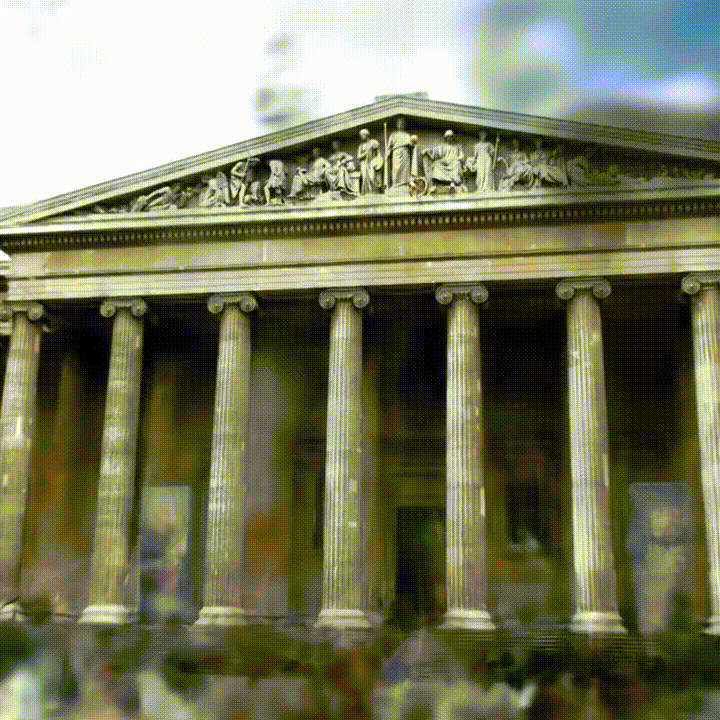

In [ ]:
def main():
    """Main execution function"""
    print("="*60)
    print("Gaussian Splatting Generation from MP4 Video")
    print("="*60)
    try:
        # Step 1: Environment Setup
        setup_environment()

        # Step 2: Extract Frames from Video
        frame_dir = f"{COLMAP_DIR}/images"
        process_frames_from_folder(IMAGE_PATH, frame_dir, max_frames=300)

        # Step 2.5: Normalize Image Sizes (NEW)
        print("\n" + "="*60)
        print("Step 2.5: Normalizing image sizes...")
        print("="*60)
        normalize_image_sizes(frame_dir, target_size=1200)

        # Step 3: Estimate Camera Info with COLMAP
        colmap_model_dir = run_colmap_reconstruction(frame_dir, COLMAP_DIR)

        # Step 4: Prepare Data for Gaussian Splatting
        data_dir = prepare_gaussian_splatting_data(frame_dir, colmap_model_dir)

        # Step 5: Train Model
        model_path = train_gaussian_splatting(data_dir, iterations=4000)

        # Step 6: Render Video
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        output_video = f"{OUTPUT_DIR}/gaussian_splatting_video.mp4"
        success = render_video(model_path, output_video, iteration=4000)

        if success:
            print("="*60)
            print(f"Success! Video generation complete: {output_video}")
            print("="*60)

            # Create GIF
            output_gif = f"{OUTPUT_DIR}/gaussian_splatting_video.gif"
            create_gif(output_video, output_gif)

            # Display result
            from IPython.display import Image
            display(Image(open(output_gif, 'rb').read()))
        else:
            print("Warning: Rendering complete, but video was not generated")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

In [ ]:
import gc
gc.collect()

0